In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jun  1 19:57:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose,UpSampling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from keras.datasets import cifar10
import keras.backend as K
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
from sklearn.utils import shuffle
import sys
import os
import numpy as np
import random
from numpy.random import randint,randn,choice,rand
from numpy import ones,zeros,vstack
import pandas as pd
import cv2
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [0]:
def dataset_statistics():
  path, dirs, files = next(os.walk("/content/drive/My Drive/CovidxDatasetSplit/test/normal"))
  test_normal_count = len(files)
  path, dirs, files = next(os.walk("/content/drive/My Drive/CovidxDatasetSplit/test/covid19"))
  test_covid19_count = len(files)
  path, dirs, files = next(os.walk("/content/drive/My Drive/CovidxDatasetSplit/test/CT_COVID"))
  test_CT_count = len(files)
  path, dirs, files = next(os.walk("/content/drive/My Drive/CovidxDatasetSplit/test/pneumonia"))
  test_pneumonia_count = len(files)

  path, dirs, files = next(os.walk("/content/drive/My Drive/CovidxDatasetSplit/train/normal"))
  train_normal_count = len(files)
  path, dirs, files = next(os.walk("/content/drive/My Drive/CovidxDatasetSplit/train/covid19"))
  train_covid19_count = len(files)
  path, dirs, files = next(os.walk("/content/drive/My Drive/CovidxDatasetSplit/train/CT_COVID"))
  train_CT_count = len(files)
  path, dirs, files = next(os.walk("/content/drive/My Drive/CovidxDatasetSplit/train/pneumonia"))
  train_pneumonia_count = len(files)

  normal=test_normal_count+train_normal_count
  covid19=test_covid19_count+train_covid19_count
  CT=test_CT_count+train_CT_count
  pneumonia=test_pneumonia_count+train_pneumonia_count

  test_normal=test_normal_count*100/normal
  train_normal=train_normal_count*100/normal

  test_covid19=test_covid19_count*100/covid19
  train_covid19=train_covid19_count*100/covid19

  test_CT=test_CT_count*100/CT
  train_CT=train_CT_count*100/CT

  test_pneumonia=test_pneumonia_count*100/pneumonia
  train_pneumonia=train_pneumonia_count*100/pneumonia

  print("TEST DATASET__________TRAIN DATASET")
  print("normal =",test_normal_count,"          normal =",train_normal_count)
  print("covid19 =",test_covid19_count,"          covid19 =",train_covid19_count)
  print("CT =",test_CT_count,"               CT =",train_CT_count)
  print("pneumonia =",test_pneumonia_count,"       pneumonia =",train_pneumonia_count)
  print("covid19+CT =",test_CT_count+test_covid19_count,"       covid19+CT =",train_CT_count+train_covid19_count)
  print('\n')
  print("TEST DATASET__________TRAIN DATASET")
  print("normal =",test_normal,"          normal =",train_normal)
  print("covid19 =",test_covid19,"          covid19 =",train_covid19)
  print("CT =",test_CT,"               CT =",train_CT)
  print("pneumonia =",test_pneumonia,"       pneumonia =",train_pneumonia)

In [4]:
dataset_statistics()

TEST DATASET__________TRAIN DATASET
normal = 885           normal = 7983
covid19 = 30           covid19 = 237
CT = 34                CT = 315
pneumonia = 594        pneumonia = 5451
covid19+CT = 64        covid19+CT = 552


TEST DATASET__________TRAIN DATASET
normal = 9.979702300405954           normal = 90.02029769959404
covid19 = 11.235955056179776           covid19 = 88.76404494382022
CT = 9.742120343839542                CT = 90.25787965616045
pneumonia = 9.826302729528535        pneumonia = 90.17369727047146


In [0]:
DATA_PATH = '/content/drive/My Drive/NumpyArrayCovidx'
#BUFFER_SIZE=6000

SEED_SIZE=100
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16
GENERATE_SQUARE =128
CHANNELS=1
BATCH_SIZE=32
EPOCHS=30000


IMAGE_SHAPE=(GENERATE_SQUARE,GENERATE_SQUARE,CHANNELS)


In [0]:
def load_data():
  training_binary_path_covid_images = os.path.join(DATA_PATH,
          f'covid19_images.npy')
  print("Loading covid training pickle...")
  covid19_images = np.load(training_binary_path_covid_images,allow_pickle=True)
  for i in range(len(covid19_images)):
    covid19_images[i] = cv2.cvtColor(covid19_images[i], cv2.COLOR_BGR2RGB)
    covid19_images[i] = cv2.resize(covid19_images[i], (GENERATE_SQUARE, GENERATE_SQUARE))
  training_data=[]
  for item in covid19_images:
    if(CHANNELS==1):
      item = np.mean(item, axis=2)
    training_data.append(item)

  train_data = np.array(training_data)
  train_data = (train_data - 127.5) / 127.5
  return train_data

In [7]:
covid19=load_data()

Loading covid training pickle...


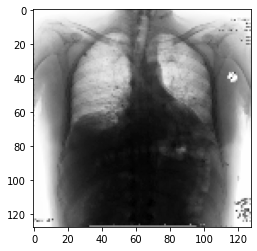

In [8]:
plt.figure()
plt.imshow(covid19[9],cmap=plt.cm.binary)

In [9]:
if(CHANNELS==1):
  covid19 = np.expand_dims(covid19, axis=3)
covid19.shape

(237, 128, 128, 1)

In [0]:
def get_generator():
  model = Sequential()
  init = RandomNormal(mean=0.0, stddev=0.02)
  model.add(Dense(256 * 4 * 4, activation='relu',input_dim=SEED_SIZE,kernel_initializer=init))
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Reshape((4, 4, 256))) #(4,4)
  #1
  model.add(Conv2DTranspose(128, 4, strides=2, padding='same',kernel_initializer=init))#(8,8)
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(alpha=0.1))
  #2
  model.add(Conv2DTranspose(128, 4, strides=2, padding='same',kernel_initializer=init))#(16,16)
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(alpha=0.1))
  #3
  model.add(Conv2DTranspose(64, 4, strides=2, padding='same',kernel_initializer=init))#(32,32)
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(alpha=0.1))
  #4
  model.add(Conv2DTranspose(32, 4, strides=2, padding='same',kernel_initializer=init))#(64,64)
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(alpha=0.1))

  model.add(Conv2DTranspose(1, 4, strides=2, padding='same',kernel_initializer=init))#(128,128)
  
  model.add(Activation("tanh"))
  return model

In [11]:
generator=get_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [0]:
#shape_input=(128,128,1)

def get_discriminator():
  model = Sequential()
  init = RandomNormal(mean=0.0, stddev=0.02)
  #1
  model.add(Conv2D(32, kernel_size=(4,4), strides=1, padding='same',input_shape=IMAGE_SHAPE,kernel_initializer=init))#(128,128)
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dropout(0.25))
  #2
  model.add(Conv2D(64, kernel_size=(4,4), strides=2, padding='same',kernel_initializer=init))#(64,64)
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dropout(0.25))
  #3
  model.add(Conv2D(128, kernel_size=(4,4), strides=2, padding='same',kernel_initializer=init))#(32,32)
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dropout(0.25))
  #4
  model.add(Conv2D(128, kernel_size=(4,4), strides=2, padding='same',kernel_initializer=init))#(16,16)
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dropout(0.25))

  model.add(Conv2D(256, kernel_size=(4,4), strides=2, padding='same',kernel_initializer=init))#(8,8)
  model.add(BatchNormalization(momentum=0.9))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(256*4*4, activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
    
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),metrics=['accuracy'])
  return model

In [13]:
discriminator= get_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      544       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 65, 65, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 65, 65, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 65, 65, 64)       

In [0]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(SEED_SIZE,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam')
    return gan

In [0]:
gan = create_gan(discriminator, generator)

In [0]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)
  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] *255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'Covid19GAN')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [0]:
def noisy_labels(y, p_flip):
  n_select = int(p_flip * y.shape[0])
  flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
  y[flip_ix] = 1 - y[flip_ix]
  return y

# [0.7, 1.2]
def smooth_positive_labels(y):
  k = y - 0.3 + np.random.uniform(low=0.0, high=1.0, size=(y.shape)) * 0.5
  return k

#[0.0, 0.3]
def smooth_negative_labels(y):
  k = y + np.random.uniform(low=0.0, high=1.0, size=(y.shape)) * 0.3
  return k

def generate_real_samples(dataset, n_samples):
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))
  y = noisy_labels(y, 0.05)
  y = smooth_positive_labels(y)
  return X, y

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = zeros((n_samples, 1))
  y = noisy_labels(y, 0.05)
  y=smooth_negative_labels(y)
  return X, y

def save(gan, generator, discriminator,epoch):
    discriminator.trainable = False
    gan.save(f"drive/My Drive/saved_models/Covid19GAN/gan-{epoch}.h5")
    print(f"GAN {epoch} SAVED")
    discriminator.trainable = True
    generator.save(f"drive/My Drive/saved_models/Covid19GAN/generator-{epoch}.h5")
    print(f"Generator {epoch} SAVED")
    discriminator.save(f"drive/My Drive/saved_models/Covid19GAN/discriminator-{epoch}.h5")
    print(f"Discriminator {epoch} SAVED")


def train(dataset,latent_dim,g_model=generator, d_model=discriminator, gan_model=gan, n_epochs=EPOCHS , n_batch=BATCH_SIZE):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(1,n_epochs+1):
    print("Epochs:",i)
    gan_loss_list = []
    disc_loss_list = []
    for j in (range(bat_per_epo)):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      d_model.trainable=True
      d_loss, _ = d_model.train_on_batch(X, y)
      d_model.trainable=False
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      #Train Twice to reduce loss
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      #print('>%d, d=%.3f, g=%.3f' % (i+1, d_loss, g_loss))
      disc_loss_list.append(d_loss)
      gan_loss_list.append(g_loss)
    dloss=sum(disc_loss_list) / len(disc_loss_list)
    ganloss=sum(gan_loss_list) / len(gan_loss_list)
    print('discr loss = ',dloss,'gan loss = ',ganloss)
    if(i%50==0):
      save_images(i,X_gan)
    if(i%10000==0):
      save(gan_model,g_model,d_model,i)

In [0]:
train(covid19,SEED_SIZE)

Epochs: 1
discr loss =  1.6056713121277946 gan loss =  2.0348565578460693
Epochs: 2
discr loss =  0.7278528809547424 gan loss =  2.057883858680725
Epochs: 3
discr loss =  0.43286084277289255 gan loss =  1.7424039329801286
Epochs: 4
discr loss =  0.43729744638715473 gan loss =  1.7563817160470145
Epochs: 5
discr loss =  0.589200884103775 gan loss =  1.4777474062783378
Epochs: 6
discr loss =  0.37783789208957125 gan loss =  0.49419533780642916
Epochs: 7
discr loss =  0.5906545945576259 gan loss =  0.34259175828524996
Epochs: 8
discr loss =  0.40852012378828867 gan loss =  0.1080531392778669
Epochs: 9
discr loss =  0.3608426238809313 gan loss =  0.16230478350605285
Epochs: 10
discr loss =  0.35918527841567993 gan loss =  0.26128522625991274
Epochs: 11
discr loss =  0.32629996857472826 gan loss =  0.2472825050354004
Epochs: 12
discr loss =  0.38758369854518343 gan loss =  0.15438859058277948
Epochs: 13
discr loss =  0.34765484077589853 gan loss =  0.4898270240851811
Epochs: 14
discr loss =